In [ ]:
import pandas as pd
import os.path
import pickle 
import numpy as np
import keras.utils
import time
from keras.callbacks import TensorBoard, CSVLogger
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Conv1D,GlobalMaxPool1D,Dropout,Bidirectional
from tensorflow.keras.layers import Embedding
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from nltk.corpus import stopwords
import operator
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
import os
os.chdir('/content/drive/My Drive/Nela-GT')

Mounted at /content/drive/


In [ ]:
basedir = '/content/drive/My Drive/Nela-GT/'
nela_db_file = basedir + 'articles.db'

**Reading the data from database**

In [ ]:
# Create the connection
cnx = sqlite3.connect(nela_db_file)
# create the dataframe from a query
nela_orig_df = pd.read_sql_query("SELECT * FROM articles", cnx)
# Close the connection
cnx.close()

In [ ]:
nela_orig_df

,date,source,name,content
0,2018-02-01,Addicting Info,Donald Trump Jr Likes Fox News Tweet About Spr...,Since Donald Trump Jr. has admitted on Twitter...
1,2018-02-01,Addicting Info,REPORT UK Will Share Less Confidential Info Wi...,The Republican-written and Republican-altered ...
2,2018-02-01,Addicting Info,Trump Jr Mocked To Oblivion After Democracy Di...,The world is still laughing at the Trump admin...
3,2018-02-01,BBC,Battling to save the worlds bananas,Visiting the Matanuska banana plantation is no...
4,2018-02-01,BBC,Escape from the asylum,"In Croatia, thousands of people with mental il..."
...,...,...,...,...
713529,2018-11-30,theRussophileorg,US Sanctions Have Become Little More Than Medi...,The new unilateral sanctions by the United Sta...
713530,2018-11-30,theRussophileorg,US has long record of institutionalized target...,This\r\n\r\n[post](http://www.presstv.ir/Detai...
713531,2018-11-30,theRussophileorg,US insists on return of detained Ukrainian sai...,This\r\n\r\n[post](http://tass.com/world/10335...
713532,2018-11-30,theRussophileorg,US official Military action on the table again...,This\r\n\r\n[post](http://www.presstv.ir/Detai...


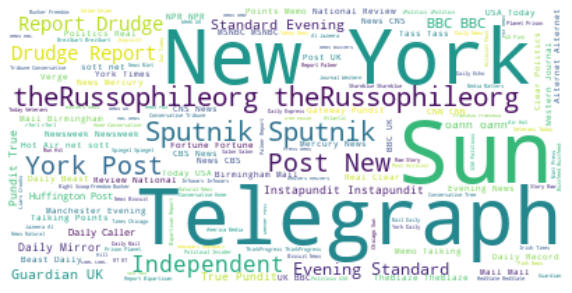

In [ ]:
#word Cloud


from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

text = " ".join(i for i in nela_orig_df.source)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


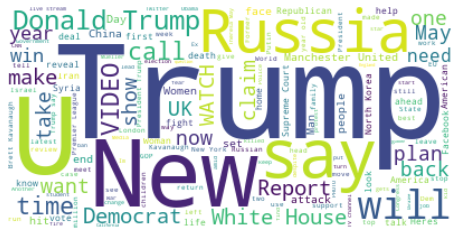

In [ ]:
from wordcloud import STOPWORDS
text = " ".join(i for i in nela_orig_df.name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**Getting labels from csv file**

In [ ]:
labels_file  = basedir + 'labels.csv'
labels_df = pd.read_csv(labels_file, sep=',')
print(labels_df.shape)
labels_df.head()

(194, 58)


,Unnamed: 0,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing","NewsGuard, Clearly labels advertising","NewsGuard, Reveals who's in charge, including any possible conflicts of interest","NewsGuard, Provides information about content creators",...,"Allsides, community_agree","Allsides, community_disagree","Allsides, community_label","BuzzFeed, leaning","PolitiFact, Pants on Fire!","PolitiFact, False","PolitiFact, Mostly False","PolitiFact, Half-True","PolitiFact, Mostly True","PolitiFact, True"
0,21stCenturyWire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
1,ABC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,8964.0,6949.0,somewhat agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMERICAblog News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
3,Activist Post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
4,Addicting Info,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN


**Rename the Unnamed column in labels_file to match as source**

Precleaning - Drop rows for sources having all column values as NaN

In [ ]:
labels_df.rename(columns={labels_df.columns[0]: "source" }, inplace = True)
alllblcolumns = labels_df.columns.tolist()
alllblcolumns.remove('source')
labels_df.dropna(axis=0, how='all', inplace=True, subset=alllblcolumns)
labels_df.shape

(155, 58)

In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 192
Data columns (total 58 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   source                                                                            155 non-null    object 
 1   NewsGuard, Does not repeatedly publish false content                              85 non-null     float64
 2   NewsGuard, Gathers and presents information responsibly                           85 non-null     float64
 3   NewsGuard, Regularly corrects or clarifies errors                                 85 non-null     float64
 4   NewsGuard, Handles the difference between news and opinion responsibly            85 non-null     float64
 5   NewsGuard, Avoids deceptive headlines                                             85 non-null     float64
 6   Ne

In [ ]:
nela_orig_df.shape

(713534, 4)

In [ ]:
nan_value = float("NaN")
nela_orig_df.replace("", nan_value, inplace=True)
nela_orig_df.dropna(inplace=True)
nela_orig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712537 entries, 0 to 713533
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     712537 non-null  object
 1   source   712537 non-null  object
 2   name     712537 non-null  object
 3   content  712537 non-null  object
dtypes: object(4)
memory usage: 27.2+ MB


**SNS count plot visualizations for the nela_orig_df from different sources**

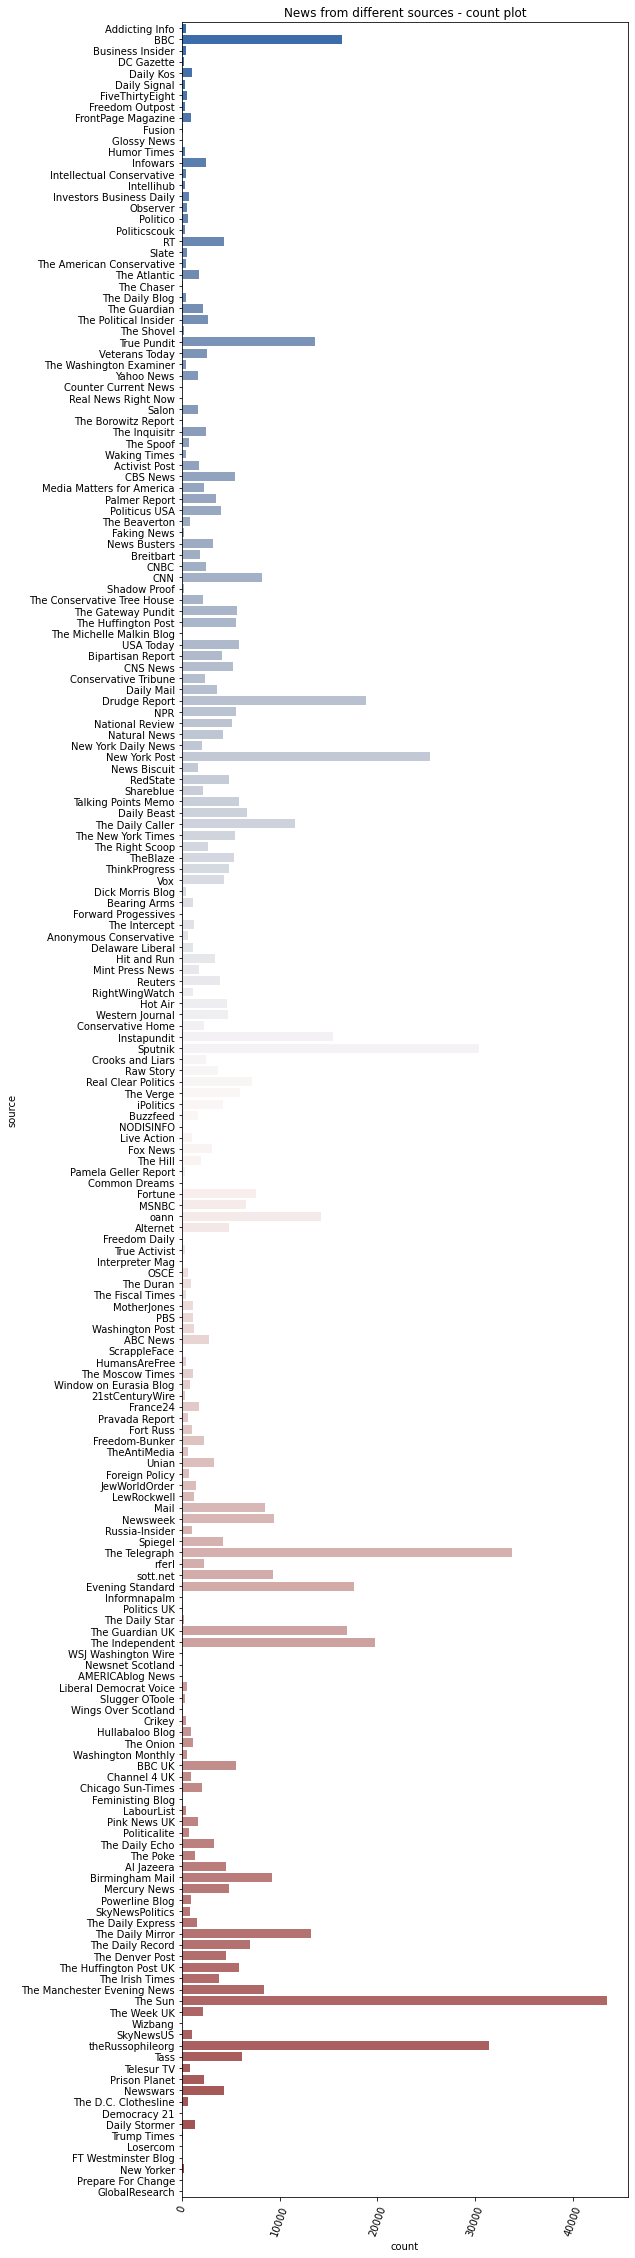

In [ ]:

f, ax = plt.subplots(1,1, figsize = (8, 40))
sns.countplot(y=nela_orig_df['source'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('News from different sources - count plot')
plt.show()

In [ ]:
nela_orig_df.head()

,date,source,name,content
0,2018-02-01,Addicting Info,Donald Trump Jr Likes Fox News Tweet About Spr...,Since Donald Trump Jr. has admitted on Twitter...
1,2018-02-01,Addicting Info,REPORT UK Will Share Less Confidential Info Wi...,The Republican-written and Republican-altered ...
2,2018-02-01,Addicting Info,Trump Jr Mocked To Oblivion After Democracy Di...,The world is still laughing at the Trump admin...
3,2018-02-01,BBC,Battling to save the worlds bananas,Visiting the Matanuska banana plantation is no...
4,2018-02-01,BBC,Escape from the asylum,"In Croatia, thousands of people with mental il..."


**The original NELA_GT dataset has 700k+ rows and 4 columns.**

Since the number of rows are higher, the time it takes to process the dataset cleaning and running algorithms is considerably in many hours. So I am shuffeling the original nela dataset with a random_state=1000. This would make sure everytime the notebook is run, same shuffeling is retained. Out of 700k+ rows, I'll be selecting around 5k rows for the project.

In [ ]:
import sklearn
nela_orig_shuf_df = sklearn.utils.shuffle(nela_orig_df, random_state=1000).reset_index(drop=True).copy()
nela_df = nela_orig_shuf_df.head(50000).copy()
nela_df.head(5)

,date,source,name,content
0,2018-11-16,The Independent,Arecibo message What happened when people clai...,When the Arecibo message was sent into space i...
1,2018-08-29,Prison Planet,CNN Contributor Mike Pence Is A Christian Supr...,"According to CNN contributor Michael DAntonio,..."
2,2018-10-08,The Telegraph,Four sisters among 20 dead in horror limo cras...,"A limousine carrying four sisters, other relat..."
3,2018-11-05,The Guardian UK,Inside the campaign to stop Brexit podcast,As Brexit negotiations gear up again this week...
4,2018-04-23,BBC,Toronto collision Pedestrians injured after va...,Up to 10 pedestrians have been struck by a van...


**Combining the data with labels**

In [ ]:
nela_merge_df = nela_df.merge(labels_df, on="source", how = 'inner')
nela_labels_df = sklearn.utils.shuffle(nela_merge_df, random_state=100).reset_index(drop=True).copy()
nela_labels_df_backup = nela_labels_df.copy()

In [ ]:
nela_labels_df.head(5)

,date,source,name,content,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing",...,"Allsides, community_agree","Allsides, community_disagree","Allsides, community_label","BuzzFeed, leaning","PolitiFact, Pants on Fire!","PolitiFact, False","PolitiFact, Mostly False","PolitiFact, Half-True","PolitiFact, Mostly True","PolitiFact, True"
0,2018-04-30,Western Journal,Public School Teacher Allegedly Compared Pro-G...,"A Parkland, Florida, history teacher allegedly...",1.0,1.0,0.0,1.0,1.0,0.0,...,759.0,319.0,strongly agree,right,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-15,Daily Beast,Inside Aaron Hernandezs Perfect World and His ...,O.J. Simpson was accused of murdering his ex-w...,0.0,0.0,0.0,0.0,0.0,0.0,...,4427.0,3503.0,somewhat agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-03,True Pundit,George Soros Pulls Out of San Diegos District ...,A political action committee launched and bank...,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,right,1.0,0.0,0.0,0.0,0.0,0.0
3,2018-09-24,The Telegraph,Italy adopts decree to make it easier to expel...,Italys populist coalition passed a bill on Mon...,NaN,NaN,NaN,NaN,NaN,NaN,...,417.0,238.0,agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-20,The Gateway Pundit,HERE WE GO- Hillary Clinton Spox Calls on Hous...,"No classified emails were exchanged, no emails...",1.0,1.0,1.0,1.0,1.0,0.0,...,371.0,236.0,agree,right,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
nela_labels_df.shape

(4232, 61)

**Encoding the all labels to come to common ground**

In [ ]:
#Encoding NewsGuard Label content

def encode_newsguard(input_label):
    if input_label == 1:
        return 1
    elif input_label == 0:
        return 0
    else:
        return input_label
nela_labels_df['newsguard_label'] = nela_labels_df.apply(lambda row: encode_newsguard(row['NewsGuard, overall_class']), axis=1)

In [ ]:
#Encoding Pew Research Center content

def encode_pewresearch(input_label):
    if input_label == 1:
        return 1
    elif input_label == 0:
        return 0
    else:
        return input_label
nela_labels_df['pewresearch_label'] = nela_labels_df.apply(lambda row: encode_pewresearch(row['Pew Research Center, known_by_40%']), axis=1)

In [ ]:
#Encoding Wikipedia label
def encode_wikipedia(input_label):
    if input_label == 0:
        return 1
    elif input_label == 1:
        return 0
    else:
        return input_label
nela_labels_df['wikipedia_label'] = nela_labels_df.apply(lambda row: encode_wikipedia(row['Wikipedia, is_fake']), axis=1)

In [ ]:
# Encoding OpenSource Bias label

def encode_opensourcebias(input_label):
    # bias left
    if input_label == 1:
        return 0
    # bias right
    elif input_label > 1:
        return 1
    else:
        return input_label
nela_labels_df['opensourcebias_label'] = nela_labels_df.apply(lambda row: encode_opensourcebias(row['Open Sources, bias']), axis=1)

In [ ]:
# Encoding Media Bias / Fact Check, label
labels_df['Media Bias / Fact Check, label'].unique()

array(['conspiracy_pseudoscience', 'left_center_bias', nan, 'left_bias',
       'right_bias', 'questionable_source', 'right_center_bias',
       'least_biased', 'satire'], dtype=object)

In [ ]:
true_labels = ['right_bias','right_center_bias','least_biased']
false_labels = ['conspiracy_pseudoscience','left_bias','left_center_bias', 'questionable_source', 'satire']

def encode_mediabias(input_label):
    if input_label in true_labels:
        return 1
    elif input_label in false_labels:
        return 0
    else:
        return input_label
nela_labels_df['mediabias_label'] = nela_labels_df.apply(lambda row: encode_mediabias(row['Media Bias / Fact Check, label']), axis=1)

In [ ]:
#Encoding Allsides, community_label
labels_df['Allsides, community_label'].unique()

array([nan, 'somewhat agree', 'somewhat disagree', 'strongly agree',
       'agree', 'strongly disagree', 'absolutely agree', 'disagree'],
      dtype=object)

In [ ]:
true_labels = ['somewhat agree','strongly agree','agree', 'absolutely agree']
false_labels = ['somewhat disagree','strongly disagree','disagree']

def encode_allsideslabel(input_label):
    if input_label in true_labels:
        return 1
    elif input_label in false_labels:
        return 0
    else:
        return input_label
nela_labels_df['allsides_label'] = nela_labels_df.apply(lambda row: encode_allsideslabel(row['Allsides, community_label']), axis=1)

In [ ]:
# Encoding BuzzFeed, leaning
labels_df['BuzzFeed, leaning'].unique()

array(['left', nan, 'right'], dtype=object)

In [ ]:
true_labels = ['right']
false_labels = ['left']

def encode_buzzfeedlabel(input_label):
    if input_label in true_labels:
        return 1
    elif input_label in false_labels:
        return 0
    else:
        return input_label
nela_labels_df['buzzfeed_label'] = nela_labels_df.apply(lambda row: encode_buzzfeedlabel(row['BuzzFeed, leaning']), axis=1)

In [ ]:
# Encoding Politifact Label
# PolitiFact, Pants on Fire!
# PolitiFact, False
# PolitiFact, Mostly False
# PolitiFact, Half-True
# PolitiFact, Mostly True
# PolitiFact, True

nela_labels_df['politifact_true_count'] = nela_labels_df['PolitiFact, Half-True'] + nela_labels_df['PolitiFact, Mostly True'] + nela_labels_df['PolitiFact, True']
nela_labels_df['politifact_false_count'] = nela_labels_df['PolitiFact, Pants on Fire!'] + nela_labels_df['PolitiFact, False'] + nela_labels_df['PolitiFact, Mostly False']
nela_labels_df.head()


,date,source,name,content,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing",...,"PolitiFact, True",newsguard_label,pewresearch_label,wikipedia_label,opensourcebias_label,mediabias_label,allsides_label,buzzfeed_label,politifact_true_count,politifact_false_count
0,2018-02-08,Yahoo News,Leadership urges House Democrats to vote again...,"WASHINGTON With a potential shutdown looming,...",0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN
1,2018-05-31,Buzzfeed,Alabama Republicans Condemn Candidate Months A...,The Alabama Republican Party stuck with Roy Mo...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0
2,2018-10-31,RT,Birthright citizenship not covered by US const...,President Donald Trump said that the US Consti...,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-10-07,The Sun,Who is on The Jonathan Ross Show this week Gor...,THE Jonathan Ross Show is back on our screens ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2018-10-15,Drudge Report,SAUDI STORM,A handout picture provided by the Saudi Royal ...,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,2.0


In [ ]:

def encode_politifactlabel(true_label, false_label):
    if np.isnan(true_label) or np.isnan(false_label):
        return true_label
    elif true_label > false_label:
        return 1
    else:
        return 0
nela_labels_df['politifact_label'] = nela_labels_df.apply(lambda row: encode_politifactlabel(row['politifact_true_count'], row['politifact_false_count']), axis=1)

In [ ]:
nela_labels_df.head()

,date,source,name,content,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing",...,newsguard_label,pewresearch_label,wikipedia_label,opensourcebias_label,mediabias_label,allsides_label,buzzfeed_label,politifact_true_count,politifact_false_count,politifact_label
0,2018-04-30,Western Journal,Public School Teacher Allegedly Compared Pro-G...,"A Parkland, Florida, history teacher allegedly...",1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,NaN,NaN,0.0,1.0,1.0,1.0,NaN,NaN,NaN
1,2018-11-15,Daily Beast,Inside Aaron Hernandezs Perfect World and His ...,O.J. Simpson was accused of murdering his ex-w...,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
2,2018-06-03,True Pundit,George Soros Pulls Out of San Diegos District ...,A political action committee launched and bank...,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,NaN,NaN,0.0,0.0,NaN,1.0,0.0,1.0,0.0
3,2018-09-24,The Telegraph,Italy adopts decree to make it easier to expel...,Italys populist coalition passed a bill on Mon...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
4,2018-11-20,The Gateway Pundit,HERE WE GO- Hillary Clinton Spox Calls on Hous...,"No classified emails were exchanged, no emails...",1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,NaN,NaN,0.0,0.0,1.0,1.0,2.0,1.0,1.0


**Encoding final label value based on the count of encoded labels**


*   encoded_label value is set to 1 / 0 based on the binary values of ['newsguard_label', 'pewresearch_label', 'wikipedia_label', 'opensourcebias_label', 'mediabias_label', 'allsides_label', 'buzzfeed_label', 'politifact_label']
*   final encoded label is found based on the number of positives or negatives for all the above labels


*   Eg: If for a row, newsguard_label value=1, mediabias_label=1, allsides_label=0, buzzfeed_label=1, and rest all other columns are NaN pos = 3, neg = 1

  (pos - neg) is > 0 so encoded_label = 1

*  Eg: If for a row, newsguard_label value=0, mediabias_label=0, allsides_label=0, buzzfeed_label=1, and rest all other columns are NaN pos = 1, neg = 3

  (pos - neg) is < 0 so encoded_label = 0







In [ ]:
encoded_columns = ['newsguard_label', 'pewresearch_label', 'wikipedia_label', 'opensourcebias_label',
                    'mediabias_label', 'allsides_label', 'buzzfeed_label', 'politifact_label']

nela_labels_df['encoded_label'] = -100

for i in range(nela_labels_df.shape[0]):
    pos = 0
    neg = 0
    for col in encoded_columns:
        if nela_labels_df[col][i] == 1:
            pos = pos + 1
        elif nela_labels_df[col][i] == 0:
            neg = neg + 1
    if pos > neg:
        nela_labels_df.at[i, 'encoded_label'] = 1
        
    elif pos < neg:
        nela_labels_df.at[i, 'encoded_label'] = 0
        

nela_labels_df = nela_labels_df[(nela_labels_df[['encoded_label']] != -100).all(axis=1)]
nela_labels_df.reset_index(drop=True, inplace=True)

print(nela_labels_df['encoded_label'].value_counts())
print(nela_labels_df.shape)

1    22262
0    13986
Name: encoded_label, dtype: int64
(36248, 72)


In [ ]:
nela_labels_df.head(5)

,date,source,name,content,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing",...,pewresearch_label,wikipedia_label,opensourcebias_label,mediabias_label,allsides_label,buzzfeed_label,politifact_true_count,politifact_false_count,politifact_label,encoded_label
0,2018-04-30,Western Journal,Public School Teacher Allegedly Compared Pro-G...,"A Parkland, Florida, history teacher allegedly...",1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1
1,2018-11-15,Daily Beast,Inside Aaron Hernandezs Perfect World and His ...,O.J. Simpson was accused of murdering his ex-w...,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1
2,2018-06-03,True Pundit,George Soros Pulls Out of San Diegos District ...,A political action committee launched and bank...,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0
3,2018-09-24,The Telegraph,Italy adopts decree to make it easier to expel...,Italys populist coalition passed a bill on Mon...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1
4,2018-04-30,The Daily Caller,Little Girl Will Put A Smile On Your Face With...,A little girl broke the internet over the week...,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1


In [ ]:
nela_labels_df[["date","source","name","content","encoded_label"]]

,date,source,name,content,encoded_label
0,2018-04-30,Western Journal,Public School Teacher Allegedly Compared Pro-G...,"A Parkland, Florida, history teacher allegedly...",1
1,2018-11-15,Daily Beast,Inside Aaron Hernandezs Perfect World and His ...,O.J. Simpson was accused of murdering his ex-w...,1
2,2018-06-03,True Pundit,George Soros Pulls Out of San Diegos District ...,A political action committee launched and bank...,0
3,2018-09-24,The Telegraph,Italy adopts decree to make it easier to expel...,Italys populist coalition passed a bill on Mon...,1
4,2018-04-30,The Daily Caller,Little Girl Will Put A Smile On Your Face With...,A little girl broke the internet over the week...,1
...,...,...,...,...,...
14413,2018-02-27,New York Daily News,Retired NYPD cop rips Trumps proposal to arm t...,I teach special education for the NYC Departme...,1
14414,2018-11-20,TheAntiMedia,Airbnb Ends West Bank Settlement Listings Caus...,(MEE) Home rental company Airbnb has announce...,0
14415,2018-09-21,The Daily Express,Mays INCAPABLE of delivering good Brexit deal ...,The Prime Minister this afternoon warned the E...,1
14416,2018-11-30,Birmingham Mail,We predict how many points Birmingham City wil...,A tally of six fixtures will be jam packed int...,0


In [ ]:
# nela_labels_df[["date","source","name","content","encoded_label"]]
frequent_source = nela_labels_df['source'].value_counts()[:30].reset_index().to_dict()['index']
frequent_source = dict((v,k) for k,v in frequent_source.items())


In [ ]:
frequent_source

{'The Sun': 0,
 'The Telegraph': 1,
 'Sputnik': 2,
 'New York Post': 3,
 'Drudge Report': 4,
 'Evening Standard': 5,
 'BBC': 6,
 'Instapundit': 7,
 'oann': 8,
 'The Daily Mirror': 9,
 'True Pundit': 10,
 'The Daily Caller': 11,
 'sott.net': 12,
 'Birmingham Mail': 13,
 'Fortune': 14,
 'Daily Beast': 15,
 'CNN': 16,
 'Real Clear Politics': 17,
 'The Daily Record': 18,
 'The Verge': 19,
 'Talking Points Memo': 20,
 'The New York Times': 21,
 'USA Today': 22,
 'National Review': 23,
 'Tass': 24,
 'CNS News': 25,
 'CBS News': 26,
 'Hot Air': 27,
 'NPR': 28,
 'RedState': 29}

In [ ]:
def get_source_id(source):
  if isinstance(source, str):
    matched = [sp for sp in frequent_source if sp in source ]
    if len(matched)>0:
      return frequent_source[matched[0]]
    else:
      return len(set(frequent_source.values())) 
  else:
    return len(set(frequent_source.values())) 

nela_labels_df["source_id"] = nela_labels_df["source"].apply(get_source_id)

In [ ]:
nela_labels_df

,date,source,name,content,"NewsGuard, Does not repeatedly publish false content","NewsGuard, Gathers and presents information responsibly","NewsGuard, Regularly corrects or clarifies errors","NewsGuard, Handles the difference between news and opinion responsibly","NewsGuard, Avoids deceptive headlines","NewsGuard, Website discloses ownership and financing",...,wikipedia_label,opensourcebias_label,mediabias_label,allsides_label,buzzfeed_label,politifact_true_count,politifact_false_count,politifact_label,encoded_label,source_id
0,2018-04-30,Western Journal,Public School Teacher Allegedly Compared Pro-G...,"A Parkland, Florida, history teacher allegedly...",1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1,30
1,2018-11-15,Daily Beast,Inside Aaron Hernandezs Perfect World and His ...,O.J. Simpson was accused of murdering his ex-w...,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1,15
2,2018-06-03,True Pundit,George Soros Pulls Out of San Diegos District ...,A political action committee launched and bank...,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0,10
3,2018-09-24,The Telegraph,Italy adopts decree to make it easier to expel...,Italys populist coalition passed a bill on Mon...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1,1
4,2018-04-30,The Daily Caller,Little Girl Will Put A Smile On Your Face With...,A little girl broke the internet over the week...,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14413,2018-02-27,New York Daily News,Retired NYPD cop rips Trumps proposal to arm t...,I teach special education for the NYC Departme...,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1,30
14414,2018-11-20,TheAntiMedia,Airbnb Ends West Bank Settlement Listings Caus...,(MEE) Home rental company Airbnb has announce...,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0,30
14415,2018-09-21,The Daily Express,Mays INCAPABLE of delivering good Brexit deal ...,The Prime Minister this afternoon warned the E...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,30
14416,2018-11-30,Birmingham Mail,We predict how many points Birmingham City wil...,A tally of six fixtures will be jam packed int...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,13


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#spacy is for nlp 
# !python -m spacy download en_core_web_sm
!pip install spacy==3.4.1
import spacy
# !python -m spacy download en
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 14.6 MB/s 
     |████████████████████████████████| 12.8 MB 65.0 MB/s 
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Encoding of the **statement**

In [ ]:
def load_statement_vocab_dict(nela_labels_df):
  vocabulary_dict = {}
  #checking if pickle file already exists
  if not os.path.exists('vocabulary.p'):
    #tokenisation is to segregate a text into small chuncks. Like "Let's complete the task" to "let's","complete","the","task".
    #fit_on_texts method is a part of Keras tokenizer class which is used to update the internal vocabulary for the texts list
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(nela_labels_df['content'])

    #In this dictionary, we have unique integers assigned to each word.
    vocabulary_dict = tokenizer.word_index
    print(len(vocabulary_dict))
    pickle.dump(vocabulary_dict, open( "vocabulary.p", "wb" ))
    print('Created Vocabulary Dictionary...')
    print('Saved Vocabulary Dictionary...')
  else:
    print('Loading Vocabulary Dictionary...')
    vocabulary_dict = pickle.load(open("vocabulary.p", "rb" ))
  return vocabulary_dict

#preprocessing excluding stopwords. Then making a word id feature to store ids of words of statement in form of vectors
#like "stock market crashed" -> [302 488 989]

def preprocess_statement(statement):
  statement = [w for w in statement.split(' ') if w not in stopwords.words('english')]
  statement = ' '.join(statement)

  #converting sentence into list of individual list of word
  text = text_to_word_sequence(statement)
  val = [0] * 10
  val = [vocabulary_dict[t] for t in text if t in vocabulary_dict] 
  return val



vocabulary_dict = load_statement_vocab_dict(nela_labels_df)
nela_labels_df['word_id'] = nela_labels_df['content'].apply(preprocess_statement)



Loading Vocabulary Dictionary...


In [ ]:
len(nela_labels_df['word_id'][60])

152

In [ ]:
#word embeddings
embeddings = {}
with open("glove.6B.100d.txt") as file_object:
  for line in file_object:
    word_embed = line.split()
    word = word_embed[0]
    embed = np.array(word_embed[1:], dtype="float32")
    embeddings[word.lower()]= embed

EMBED_DIM = 100
print(str(len(embeddings))+" : Word Embeddings Found")
print(len(embeddings[word]), " : Embedding Dimension")

#now we are making embedding matrix of our vocabulary 
num_words = len(vocabulary_dict) + 1
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in vocabulary_dict.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embeddings_index = None


400000 : Word Embeddings Found
100  : Embedding Dimension


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.18427999,  0.33845001,  0.64138001, ...,  0.73756999,
        -0.24076   ,  0.56130999],
       [-0.37887001,  0.42532   ,  0.56963998, ...,  0.31294999,
        -0.89819998, -0.65878999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#Hyper parameters
vocab_length = len(vocabulary_dict.keys())
hidden_size = EMBED_DIM #Has to be same as EMBED_DIM
lstm_size = 100
num_steps = 400
num_epochs = 10
batch_size = 128


#Meta data related hyper params
num_source = len(nela_labels_df.source_id.unique())
print(num_source)

31


**Split the nela_df to train_news and test_news and val_news**

In [ ]:
from sklearn.model_selection import train_test_split

train_news, test_news = train_test_split(nela_labels_df, test_size=0.2)
train_news, val_news  = train_test_split(train_news, test_size=0.25) # 0.25 x 0.8 = 0.2



**Data Prep**

In [ ]:
from keras_preprocessing.sequence import pad_sequences

x_train = train_news['word_id']
x_val = val_news['word_id']
x_test = test_news['word_id']

y_train = train_news['encoded_label']
y_val = val_news['encoded_label']

x_train = pad_sequences(x_train, maxlen=num_steps, padding='post',truncating='post')
x_val = pad_sequences(x_val, maxlen=num_steps, padding='post',truncating='post')
x_test = pad_sequences(x_test, maxlen=num_steps, padding='post',truncating='post')


x_train_meta = keras.utils.to_categorical(train_news['source_id'], num_classes=num_source)
x_val_meta = keras.utils.to_categorical(val_news['source_id'], num_classes=num_source)
x_test_meta = keras.utils.to_categorical(test_news['source_id'], num_classes=num_source)



**Train**

In [ ]:
from matplotlib import pyplot as plt
def train(model, name):
  sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
  model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
  tb = TensorBoard()
  csv_logger = keras.callbacks.CSVLogger('training.log')
  filepath= name+"_weights_best.hdf5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')
  # history=model.fit(
  #    {'main_input': x_train , 'aux_input': x_train_meta
  #        },
  #       y=y_train, epochs = num_epochs, batch_size = batch_size,
  #       validation_data = (
  #           {'main_input': x_val , 'aux_input': x_val_meta
  #             },
  #           y_val
  #   ),callbacks=[tb,csv_logger,checkpoint])
  history=model.fit(
     x_train,y_train, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            x_val,
            y_val
    ),callbacks=[tb,csv_logger,checkpoint])
  
  plt.plot(history.history['accuracy'])

  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show() 
  

**Evaluate**

In [ ]:
from sklearn.metrics import accuracy_score
def evaluate(name):
  model1 = load_model(name+'_weights_best.hdf5')

  # preds = model1.predict([x_test , x_test_meta], batch_size=batch_size, verbose=1)
  preds = model1.predict(x_test, batch_size=batch_size, verbose=1)
  Y_test_gt = test_news['encoded_label']

  for p in range(len(preds)):
    if(preds[p]>0.5):
      preds[p]=1
    else:
      preds[p]=0

  print(accuracy_score(Y_test_gt,preds))
  


  

**LSTM**

In [ ]:

# LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_length+1, hidden_size, input_length=num_steps))
model_lstm.add(Bidirectional(LSTM(hidden_size)))
model_lstm.add(Dense(1, activation='sigmoid'))


# statement embed LSTM
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 
lstm_in = LSTM(lstm_size,dropout=0.2)(x)


# meta data Dense
meta_input = Input(shape=(x_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)




#to concatinate meta
# x = keras.layers.concatenate([lstm_in,x_meta])
main_output = Dense(1, activation='sigmoid', name='main_output')(lstm_in) 
  
#final model with meta and statement
# model_lstm = Model(inputs=[statement_input, meta_input], outputs=[main_output])
model_lstm = Model(inputs=[statement_input], outputs=[main_output])


Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1358/1360 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6153
Epoch 1: val_accuracy improved from -inf to 0.60924, saving model to lstm_weights_best.hdf5
1360/1360 [==============================] - 27s 18ms/step - loss: 0.6660 - accuracy: 0.6154 - val_loss: 0.6669 - val_accuracy: 0.6092
Epoch 2/10
1357/1360 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.6177
Epoch 2: val_accuracy improved from 0.60924 to 0.61379, saving model to lstm_weights_best.hdf5
1360/1360 [==============================] - 26s 19ms/step - loss: 0.6635 - accuracy: 0.6178 - val_loss: 0.6665 - val_accuracy: 0.6138
Epoch 3/10
1357/1360 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6162
Epoch 3: val_accuracy did not improve from 0.61379
1360/1360 [==============================] - 27s 20ms/step - loss: 0.6629 - accuracy: 0.6161 - val_loss: 0.6692 - val_accuracy: 0.6026
Epoch 4/10
1360/1360 [==============================] - ETA: 0s - loss: 0.

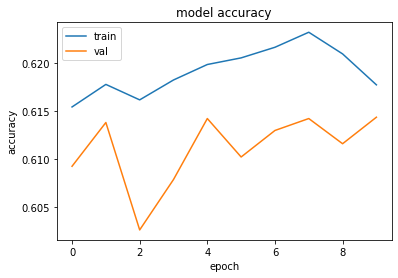

In [ ]:
train(model_lstm,'lstm')

In [ ]:
evaluate('lstm')

454/454 [==============================] - 3s 6ms/step
0.6118620689655172


**CNN**

In [ ]:
#Hyperparams for CNN
kernel_sizes = [3,3,3]
filter_size = 128

In [ ]:
kernel_stmt = []
kernel_pos = []
kernel_dep = []

statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x_stmt = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 

for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel)(x_stmt)
    x_1 = GlobalMaxPool1D()(x_1)
    kernel_stmt.append(x_1)
        
conv_in1 = keras.layers.concatenate(kernel_stmt)
conv_in1 = Dropout(0.6)(conv_in1)
conv_in1 = Dense(128, activation='relu')(conv_in1)

# meta data
meta_input = Input(shape=(x_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)

# meta and statement
#x = keras.layers.concatenate([conv_in1, x_meta])

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

model_cnn = Model(inputs=[statement_input,meta_input], outputs=[main_output])

In [ ]:
train(model_cnn,'cnn')

Epoch 1/4
215/217 [============================>.] - ETA: 0s - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1: val_categorical_accuracy improved from -inf to 1.00000, saving model to cnn_weights_best.hdf5
217/217 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 2/4
209/217 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 2: val_categorical_accuracy did not improve from 1.00000
217/217 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/4
215/217 [============================>.] - ETA: 0s - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 3: val_categorical_accuracy did not improve from 1.00000
217/217 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_l

In [ ]:
(fw, tb) = evaluate('cnn')

73/73 [==============================] - 0s 2ms/step
True
Correctly Predicted :  1084 / 2884
Accuracy :  37.586685159500696


**BERT**

In [ ]:
data = nela_labels_df[["date","source","name","content","encoded_label"]]

In [ ]:
data

,date,source,name,content,encoded_label
0,2018-02-08,Yahoo News,Leadership urges House Democrats to vote again...,"WASHINGTON With a potential shutdown looming,...",1
1,2018-05-31,Buzzfeed,Alabama Republicans Condemn Candidate Months A...,The Alabama Republican Party stuck with Roy Mo...,0
2,2018-10-31,RT,Birthright citizenship not covered by US const...,President Donald Trump said that the US Consti...,0
3,2018-10-07,The Sun,Who is on The Jonathan Ross Show this week Gor...,THE Jonathan Ross Show is back on our screens ...,1
4,2018-10-15,Drudge Report,SAUDI STORM,A handout picture provided by the Saudi Royal ...,1
...,...,...,...,...,...
36243,2018-09-04,Evening Standard,Liverpoolaposs Adam Lallana withdraws from Eng...,Liverpool midfielder Adam Lallana has withdraw...,1
36244,2018-04-26,Daily Kos,Congressional committee hearings just dont mat...,I was seriously bummed today. I made sure I wa...,0
36245,2018-04-17,New York Post,Ex-advisor to FCC Chairman Ajit Pai arrested o...,The former top broadband advisor to FCC chairm...,1
36246,2018-06-23,True Pundit,Ex-Clinton Secret Service Agent Files Conspira...,In an action thats gaining a lot of attention ...,0


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 80.2 MB/s 
     |████████████████████████████████| 7.6 MB 60.3 MB/s 


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
from transformers import BertForSequenceClassification, AdamW, BertConfig
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime

In [ ]:
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(0)
    
print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [ ]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,model_max_length=12000)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
data = data.replace({r'\r\n\r\n': ''}, regex=True)


In [ ]:
data = data.loc[data['content'].str.len()<=1000]

In [ ]:
data['content'] = data['content'].str[:480]

In [ ]:
data = data.head(5000)

In [ ]:
data

In [ ]:
statements = data.content.values
labels = data.encoded_label.values

In [ ]:
statements

array(['Over this past weekend, thousands of activists marched in Washington D.C. demanding radical gun control measures and vilifying the NRA and Republicans. However, if Google search trends are any indication, the efforts of the activists maybe backfiring.As The Daily Caller first noted, Google searches for the term NRA membership spiked during the March For Our Lives gun control rally.Data for the search term NRA membership dating back to 2004 reveals that searches for the phrase',
       'Inevitably after such a long absence, this has been the area of most concern for Andy Murray. Throughout the grass-court season Murray was still walking with a limp and looked well short of full fitness, lacking any real explosivity.In Washington this week he has still been underpowered when striking the ball, but his movement has been very impressive. In beating Kyle Edmund on Wednesday night, Murray showed flashes of the durability that made him - along with Novak Djokovic ',
       'Carson Kre

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 2 to 14415
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           3174 non-null   object
 1   source         3174 non-null   object
 2   name           3174 non-null   object
 3   content        3174 non-null   object
 4   encoded_label  3174 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 148.8+ KB


In [ ]:
max_len = 0
ind = [100,200,300,400,512]
for i in ind:
  count = 0
  for statement in statements:
      max_len = max(max_len, len(statement))
      if len(statement)>i:
        count+=1
  print("Count of sentence length over {} is: ".format(i), count)
print('Max sentence length: ', max_len)

Count of sentence length over 100 is:  4111
Count of sentence length over 200 is:  3561
Count of sentence length over 300 is:  3231
Count of sentence length over 400 is:  2969
Count of sentence length over 512 is:  0
Max sentence length:  480


In [ ]:
# Print the original sentence.
print(' Original: ', statements[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(statements[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(statements[0])))

 Original:  Over this past weekend, thousands of activists marched in Washington D.C. demanding radical gun control measures and vilifying the NRA and Republicans. However, if Google search trends are any indication, the efforts of the activists maybe backfiring.As The Daily Caller first noted, Google searches for the term NRA membership spiked during the March For Our Lives gun control rally.Data for the search term NRA membership dating back to 2004 reveals that searches for the phrase
Tokenized:  ['over', 'this', 'past', 'weekend', ',', 'thousands', 'of', 'activists', 'marched', 'in', 'washington', 'd', '.', 'c', '.', 'demanding', 'radical', 'gun', 'control', 'measures', 'and', 'vi', '##li', '##fying', 'the', 'nr', '##a', 'and', 'republicans', '.', 'however', ',', 'if', 'google', 'search', 'trends', 'are', 'any', 'indication', ',', 'the', 'efforts', 'of', 'the', 'activists', 'maybe', 'back', '##fi', '##ring', '.', 'as', 'the', 'daily', 'caller', 'first', 'noted', ',', 'google', 'sea

In [ ]:
input_ids = []
attention_masks = []
for statement in statements:
    encoded_dict = tokenizer.encode_plus(
                        statement,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', statements[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Over this past weekend, thousands of activists marched in Washington D.C. demanding radical gun control measures and vilifying the NRA and Republicans. However, if Google search trends are any indication, the efforts of the activists maybe backfiring.As The Daily Caller first noted, Google searches for the term NRA membership spiked during the March For Our Lives gun control rally.Data for the search term NRA membership dating back to 2004 reveals that searches for the phrase
Token IDs: tensor([  101,  2058,  2023,  2627,  5353,  1010,  5190,  1997, 10134,  9847,
         1999,  2899,  1040,  1012,  1039,  1012,  9694,  7490,  3282,  2491,
         5761,  1998,  6819,  3669, 14116,  1996, 17212,  2050,  1998, 10643,
         1012,  2174,  1010,  2065,  8224,  3945, 12878,  2024,  2151, 12407,
         1010,  1996,  4073,  1997,  1996, 10134,  2672,  2067,  8873,  4892,
         1012,  2004,  1996,  3679, 20587,  2034,  3264,  1010,  8224, 17193,
         2005,  1996,  2744, 

In [ ]:
tokenizer.model_max_length

512

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))



4,000 training samples
1,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            shuffle = True,
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size 
        )

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )
epochs = 2
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import random

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()        
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]
  
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        

    # Validation
    print("")
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask,labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print()
    
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('F1 score:',f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("="*10)
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Epoch 1 / 2
Training...
  Accuracy: 0.77375
  Training loss: 0.029990555331110953

Validation...
  Accuracy: 0.834
  Validation loss: 0.022345130138099193

This epoch took: 0:06:07
roc_auc score:  0.822141327010148
F1 score: 0.8779411764705883



Epoch 2 / 2
Training...
  Accuracy: 0.8945
  Training loss: 0.01697431235993281

Validation...
  Accuracy: 0.866
  Validation loss: 0.022889997091144323

This epoch took: 0:06:09
roc_auc score:  0.825786382568619
F1 score: 0.9064245810055865



Summary
Total time 0:12:16 (h:mm:ss)
